In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [3]:
df = pd.read_excel('RJ_Reconstrucao_Moluscos_2024_06_06.xlsx')
print(df.head())

    Ano  Lula_art  Lula_ind  Lula_art_ind  Lula_oceanica_art  Calamar_ind  \
0  1950       NaN       NaN           NaN                NaN          NaN   
1  1951       NaN       NaN           NaN                NaN          NaN   
2  1952       NaN       NaN           NaN                NaN          NaN   
3  1953       NaN       NaN           NaN                NaN          NaN   
4  1954       NaN       NaN           NaN                NaN          NaN   

   Polvo_art  Polvo_ind  Polvo_art_ind  Polvo_cabecinha_art  ...  \
0        NaN        NaN            NaN                  NaN  ...   
1        NaN        NaN            NaN                  NaN  ...   
2        NaN        NaN            NaN                  NaN  ...   
3        NaN        NaN            NaN                  NaN  ...   
4        NaN        NaN            NaN                  NaN  ...   

   Mexilhao_art  Mexilhao_ind  Mexilhao_mangue_art  Caramujo_art  \
0           NaN           NaN                  NaN          

In [4]:
x0 = df[['Ano', 'Polvo_art']].dropna().values
x1 = df[['Ano', 'Polvo_ind']].dropna().values


In [5]:
df_x0= pd.DataFrame(x0, columns= ['Ano', 'Polvo_art'])
df_x1=pd.DataFrame(x1, columns= ['Ano', 'Polvo_ind'])
df_x0= df_x0.drop_duplicates(subset= 'Polvo_art')
df_x1= df_x1.drop_duplicates(subset='Polvo_ind')

In [6]:
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Polvo_art'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

In [7]:
def leaky_relu(x):
    return tf.nn.RMSprop(x, alpha=0.01)

In [8]:
class PrintEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, N):
        super(PrintEveryNEpochs, self).__init__()
        self.N = N

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 0.2429499626159668
Epoch 200: loss = 0.13686133921146393
Epoch 300: loss = 0.09817090630531311
Epoch 400: loss = 0.06868161261081696
Epoch 500: loss = 0.047759827226400375
Epoch 600: loss = 0.07148988544940948
Epoch 700: loss = 0.047438930720090866
Epoch 800: loss = 0.04662585258483887
Epoch 900: loss = 0.04576622322201729
Epoch 1000: loss = 0.05156108736991882
Epoch 1100: loss = 0.05370784550905228
Epoch 1200: loss = 0.04244035482406616
Epoch 1300: loss = 0.04621344804763794
Epoch 1400: loss = 0.04505447298288345
Epoch 1500: loss = 0.041054192930459976
Epoch 1600: loss = 0.04522155225276947
Epoch 1700: loss = 0.04098450392484665
Epoch 1800: loss = 0.03706495836377144
Epoch 1900: loss = 0.04012032598257065
Epoch 2000: loss = 0.03655484691262245
Epoch 2100: loss = 0.034273963421583176
Epoch 2200: loss = 0.08373954892158508
Epoch 2300: loss = 0.03958786651492119
Epoch 2400: loss = 0.036849234253168106
Epoch 2500: loss = 0.034026943147182465
Epoch 2600: loss = 0.02593632

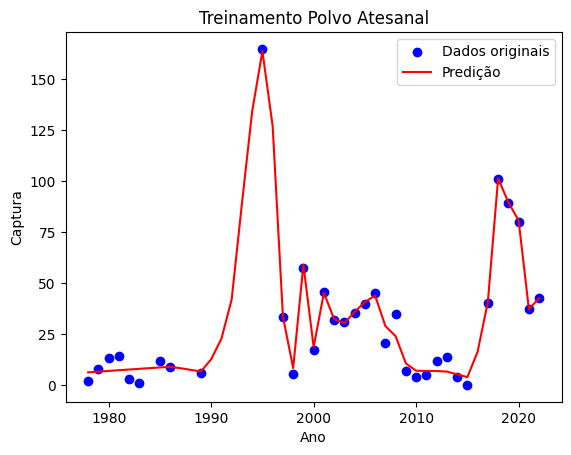

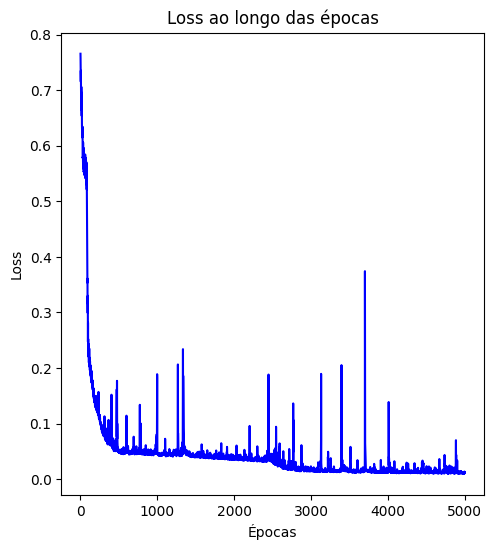

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])


print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=5000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Polvo Artesanal')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predição para o ano 1969: 2.4231224060058594
Predição para o ano 1970: 2.832059860229492
Predição para o ano 1971: 3.257843017578125
Predição para o ano 1972: 3.6860828399658203
Predição para o ano 1973: 4.116985321044922
Predição para o ano 1974: 4.55958366394043
Predição para o ano 1975: 4.963535308837891
Predição para o ano 1976: 5.38804817199707
Predição para o ano 1977: 5.812967300415039
Predição para o ano 1990: 12.60311508178711
Predição para o ano 1991: 22.719343185424805
Predição para o ano 1992: 41.967811584472656
Predição para o ano 1993: 89.00920104980469
Predição para o ano 1994: 134.32716369628906
Predição para o ano 2016: 16.338272094726562


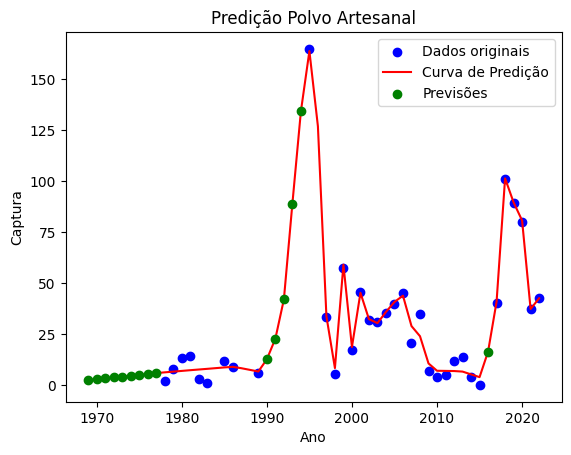

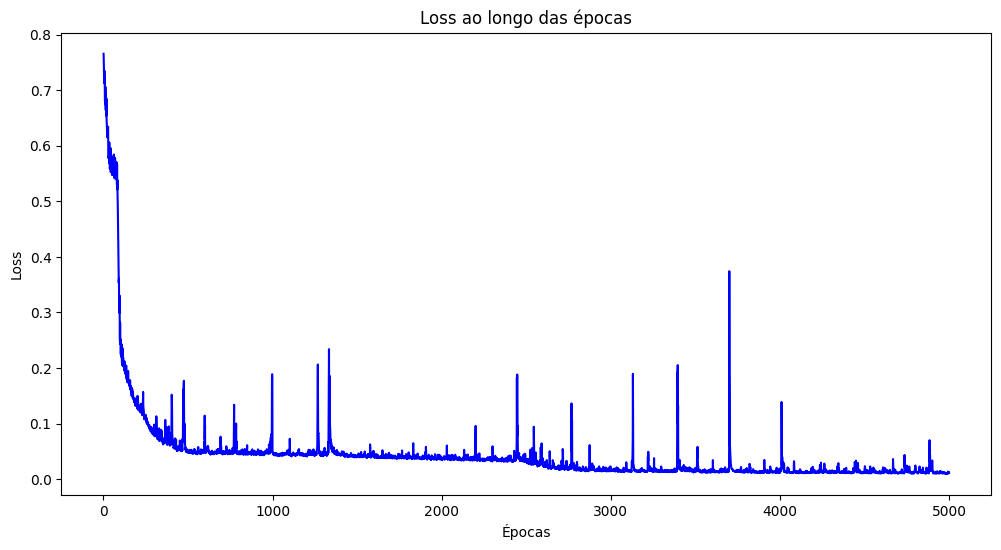

In [11]:
anos_para_prever = np.array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1990, 1991, 1992, 1993, 1994, 2016]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Polvo Artesanal')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

In [12]:
df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
print(df_combined)
df_combined.to_excel('DataFrame_reconstruido/Polvo_artesanal_reconstruido.xlsx', index=False)

       Ano  Captura Original  Captura Preditos
0   1969.0               NaN          2.423122
1   1970.0               NaN          2.832060
2   1971.0               NaN          3.257843
3   1972.0               NaN          3.686083
4   1973.0               NaN          4.116985
5   1974.0               NaN          4.559584
6   1975.0               NaN          4.963535
7   1976.0               NaN          5.388048
8   1977.0               NaN          5.812967
9   1978.0          2.000000               NaN
10  1979.0          8.000000               NaN
11  1980.0         13.000000               NaN
12  1981.0         14.000000               NaN
13  1982.0          3.000000               NaN
14  1983.0          1.000000               NaN
15  1985.0         12.000000               NaN
16  1986.0          9.000000               NaN
17  1989.0          6.000000               NaN
18  1990.0               NaN         12.603115
19  1991.0               NaN         22.719343
20  1992.0   

POLVO INDUSTRIAL

In [13]:
x = np.array(df_x1['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x1['Polvo_ind'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 0.2470681220293045
Epoch 200: loss = 0.5278059840202332
Epoch 300: loss = 0.2178141325712204
Epoch 400: loss = 0.10353910177946091
Epoch 500: loss = 0.08701498061418533
Epoch 600: loss = 0.06774859875440598
Epoch 700: loss = 0.032386600971221924
Epoch 800: loss = 0.027421189472079277
Epoch 900: loss = 0.017861848697066307
Epoch 1000: loss = 0.01662839949131012
Epoch 1100: loss = 0.032396115362644196
Epoch 1200: loss = 0.03165867552161217
Epoch 1300: loss = 0.016174709424376488
Epoch 1400: loss = 0.015421357937157154
Epoch 1500: loss = 0.020919783040881157
Epoch 1600: loss = 0.01748126558959484
Epoch 1700: loss = 0.019677599892020226
Epoch 1800: loss = 0.2186381220817566
Epoch 1900: loss = 0.17341066896915436
Epoch 2000: loss = 0.08291616290807724
Epoch 2100: loss = 0.1074790433049202
Epoch 2200: loss = 0.14155860245227814
Epoch 2300: loss = 0.025121614336967468
Epoch 2400: loss = 0.020349208265542984
Epoch 2500: loss = 0.033161938190460205
Epoch 2600: loss = 0.0433977

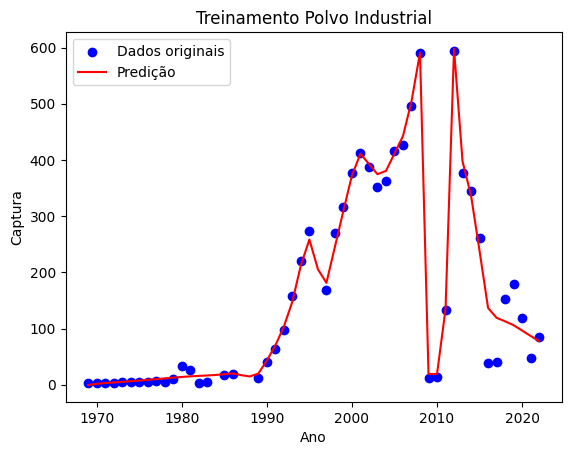

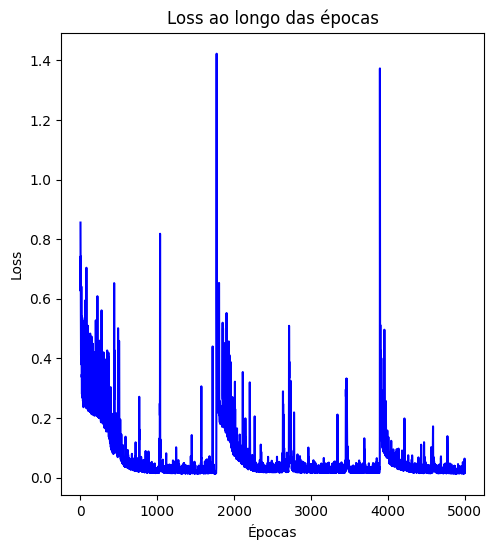

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=5000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Polvo Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predição para o ano 1969: -42.64714050292969
Predição para o ano 1970: -39.06510925292969
Predição para o ano 1971: -35.482757568359375
Predição para o ano 1972: -31.900283813476562
Predição para o ano 1973: -28.3179931640625
Predição para o ano 1974: -24.731460571289062
Predição para o ano 1975: -20.951019287109375
Predição para o ano 1976: -17.073486328125
Predição para o ano 1977: -13.191848754882812
Predição para o ano 1983: -3.3688201904296875
Predição para o ano 1990: 28.598953247070312
Predição para o ano 1991: 41.060699462890625
Predição para o ano 1992: 54.939422607421875
Predição para o ano 1993: 68.42919921875
Predição para o ano 1994: 85.1968994140625
Predição para o ano 1995: 107.765380859375


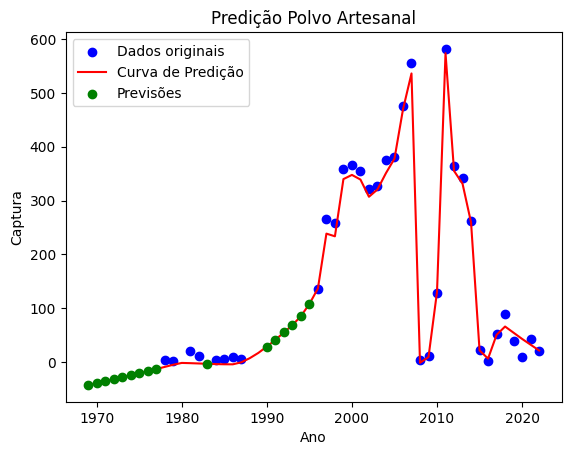

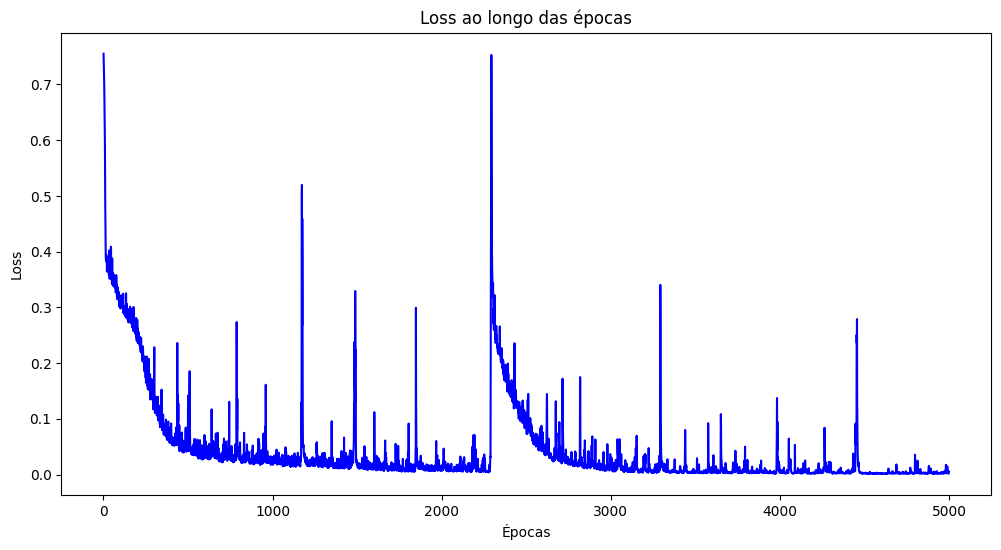

In [15]:
anos_para_prever = np.array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1983, 1990, 1991, 1992, 1993, 1994, 1995]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Polvo Artesanal')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

In [18]:
import pandas as pd
import numpy as np

df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
df_combined['Captura Original'] = df_combined['Captura Original'].clip(lower=0)
df_combined['Captura Preditos'] = df_combined['Captura Preditos'].clip(lower=0)
print(df_combined)
df_combined.to_excel('DataFrame_reconstruido/Polvo_industrial_reconstruido.xlsx', index=False)


       Ano  Captura Original  Captura Preditos
0   1969.0               NaN          0.000000
1   1970.0               NaN          0.000000
2   1971.0               NaN          0.000000
3   1972.0               NaN          0.000000
4   1973.0               NaN          0.000000
5   1974.0               NaN          0.000000
6   1975.0               NaN          0.000000
7   1976.0               NaN          0.000000
8   1977.0               NaN          0.000000
9   1978.0          3.000000               NaN
10  1979.0          2.000000               NaN
11  1981.0         20.000000               NaN
12  1982.0         12.000000               NaN
13  1983.0               NaN          0.000000
14  1984.0          4.000000               NaN
15  1985.0          5.000000               NaN
16  1986.0         10.000000               NaN
17  1987.0          6.000000               NaN
18  1990.0               NaN         28.598953
19  1991.0               NaN         41.060699
20  1992.0   

POLVO TOTAL

In [19]:
df_1 = pd.read_excel('DataFrame_reconstruido\Polvo_artesanal_reconstruido.xlsx')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Renan\AppData\Local\Temp\ipykernel_6248\1092864650.py:1: SyntaxWarning: invalid escape sequence '\P'
  df_1 = pd.read_excel('DataFrame_reconstruido\Polvo_artesanal_reconstruido.xlsx')


In [20]:
x0 = pd.DataFrame(df_1[['Ano', 'Captura Original']].fillna(0).values, columns=['Ano', 'Captura Original'])
x1 = pd.DataFrame(df_1[['Ano', 'Captura Preditos']].fillna(0).values, columns=['Ano', 'Captura Preditos'])

In [21]:
resultado = x0['Captura Original'] + x1['Captura Preditos']

novo_df1 = pd.DataFrame({'Ano': df_1['Ano'], 'Lula_art': resultado})

print(novo_df1)

     Ano    Lula_art
0   1969    2.423122
1   1970    2.832060
2   1971    3.257843
3   1972    3.686083
4   1973    4.116985
5   1974    4.559584
6   1975    4.963535
7   1976    5.388048
8   1977    5.812967
9   1978    2.000000
10  1979    8.000000
11  1980   13.000000
12  1981   14.000000
13  1982    3.000000
14  1983    1.000000
15  1985   12.000000
16  1986    9.000000
17  1989    6.000000
18  1990   12.603115
19  1991   22.719343
20  1992   41.967812
21  1993   89.009201
22  1994  134.327164
23  1995  165.000000
24  1997   33.500000
25  1998    5.500000
26  1999   57.500000
27  2000   17.000000
28  2001   45.500000
29  2002   32.000000
30  2003   31.000000
31  2004   35.500000
32  2005   39.500000
33  2006   45.000000
34  2007   20.500000
35  2008   35.041000
36  2009    7.000000
37  2010    3.728000
38  2011    4.711000
39  2012   11.939000
40  2013   13.802000
41  2014    3.823000
42  2015    0.008000
43  2016   16.338272
44  2017   40.427551
45  2018  101.038300
46  2019   89

In [22]:
df_2 = pd.read_excel('DataFrame_reconstruido\Polvo_industrial_reconstruido.xlsx')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Renan\AppData\Local\Temp\ipykernel_6248\4077111323.py:1: SyntaxWarning: invalid escape sequence '\P'
  df_2 = pd.read_excel('DataFrame_reconstruido\Polvo_industrial_reconstruido.xlsx')


In [23]:
x2 = pd.DataFrame(df_2[['Ano', 'Captura Original']].fillna(0).values, columns=['Ano', 'Captura Original'])
x3 = pd.DataFrame(df_2[['Ano', 'Captura Preditos']].fillna(0).values, columns=['Ano', 'Captura Preditos'])

In [24]:
resultado_2 = x2['Captura Original'] + x3['Captura Preditos']

novo_df_2 = pd.DataFrame({'Ano': df_2['Ano'], 'Lula_ind': resultado_2})

print(novo_df_2)

     Ano    Lula_ind
0   1969    0.000000
1   1970    0.000000
2   1971    0.000000
3   1972    0.000000
4   1973    0.000000
5   1974    0.000000
6   1975    0.000000
7   1976    0.000000
8   1977    0.000000
9   1978    3.000000
10  1979    2.000000
11  1981   20.000000
12  1982   12.000000
13  1983    0.000000
14  1984    4.000000
15  1985    5.000000
16  1986   10.000000
17  1987    6.000000
18  1990   28.598953
19  1991   41.060699
20  1992   54.939423
21  1993   68.429199
22  1994   85.196899
23  1995  107.765381
24  1996  135.000000
25  1997  265.000000
26  1998  258.500000
27  1999  359.500000
28  2000  366.500000
29  2001  355.500000
30  2002  321.000000
31  2003  327.500000
32  2004  376.000000
33  2005  381.500000
34  2006  476.000000
35  2007  555.500000
36  2008    4.284000
37  2009   10.863000
38  2010  128.988998
39  2011  581.804993
40  2012  363.782990
41  2013  341.524994
42  2014  261.919006
43  2015   22.264999
44  2016    0.944000
45  2017   51.736301
46  2018   89

In [25]:
resultado = x0['Captura Original'] + x1['Captura Preditos'] + x2['Captura Original'] + x3['Captura Preditos']

Polvo_total = pd.DataFrame({'Ano': df_1['Ano'], 'Polvo_total': resultado}).dropna()

print(Polvo_total)

       Ano  Polvo_total
0   1969.0     2.423122
1   1970.0     2.832060
2   1971.0     3.257843
3   1972.0     3.686083
4   1973.0     4.116985
5   1974.0     4.559584
6   1975.0     4.963535
7   1976.0     5.388048
8   1977.0     5.812967
9   1978.0     5.000000
10  1979.0    10.000000
11  1980.0    33.000000
12  1981.0    26.000000
13  1982.0     3.000000
14  1983.0     5.000000
15  1985.0    17.000000
16  1986.0    19.000000
17  1989.0    12.000000
18  1990.0    41.202068
19  1991.0    63.780043
20  1992.0    96.907234
21  1993.0   157.438400
22  1994.0   219.524063
23  1995.0   272.765381
24  1997.0   168.500000
25  1998.0   270.500000
26  1999.0   316.000000
27  2000.0   376.500000
28  2001.0   412.000000
29  2002.0   387.500000
30  2003.0   352.000000
31  2004.0   363.000000
32  2005.0   415.500000
33  2006.0   426.500000
34  2007.0   496.500000
35  2008.0   590.541000
36  2009.0    11.284000
37  2010.0    14.591000
38  2011.0   133.699998
39  2012.0   593.743993
40  2013.0   377

In [26]:
x = np.array(Polvo_total['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(Polvo_total['Polvo_total'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 0.38015127182006836
Epoch 200: loss = 0.3238312304019928
Epoch 300: loss = 0.2086843103170395
Epoch 400: loss = 0.3283724784851074
Epoch 500: loss = 0.21316750347614288
Epoch 600: loss = 0.08082464337348938
Epoch 700: loss = 0.18103350698947906
Epoch 800: loss = 0.15937604010105133
Epoch 900: loss = 0.06935801357030869
Epoch 1000: loss = 0.0571020282804966
Epoch 1100: loss = 0.03080678917467594
Epoch 1200: loss = 0.08032157272100449
Epoch 1300: loss = 0.03707322105765343
Epoch 1400: loss = 0.0253332257270813
Epoch 1500: loss = 0.05150216445326805
Epoch 1600: loss = 0.02611650712788105
Epoch 1700: loss = 0.051562126725912094
Epoch 1800: loss = 0.08799459785223007
Epoch 1900: loss = 0.029095761477947235
Epoch 2000: loss = 0.03981747478246689
Epoch 2100: loss = 0.038235947489738464
Epoch 2200: loss = 0.037868864834308624
Epoch 2300: loss = 0.1463502198457718
Epoch 2400: loss = 0.03429350256919861
Epoch 2500: loss = 0.022298602387309074
Epoch 2600: loss = 0.02888961881399

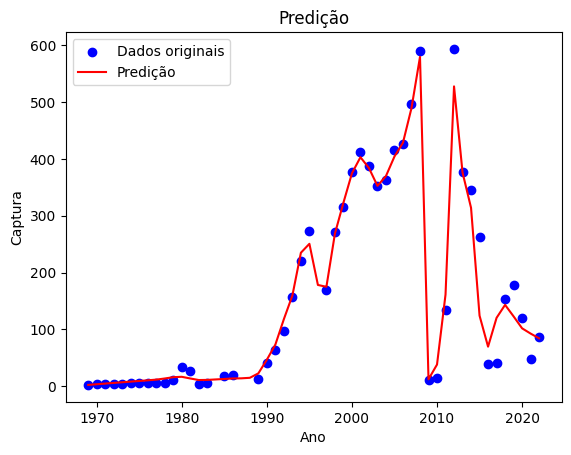

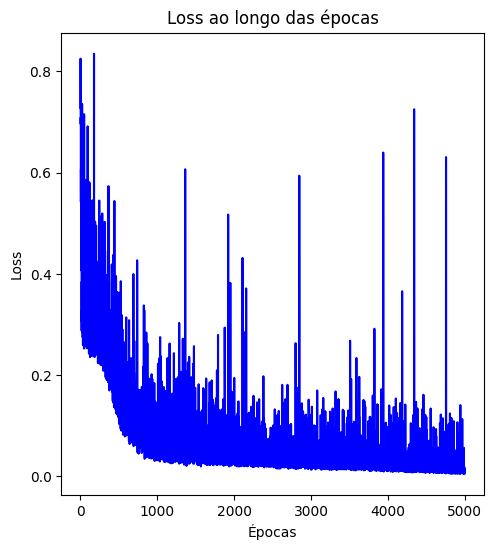

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=5000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Polvo Artesanal e Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()
